## Code for the discussed methods
- Q-learning

In [1]:
import numpy as np
import gym
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook, trange
from time import sleep
import pickle
import random
import matplotlib.pyplot as plt

### Monte-Carlo

In [2]:
env = gym.make('FrozenLake-v0')
s0 = env.reset()
env.render()
# when you make action there is 33% chance to get to another space
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3


SFFF
FHFH
FFFH
HFFG


In [3]:
def e_greedy_policy(q_table, state, k, number_of_runs, env):
    #epsilon = 0.25
    epsilon = 1 - (k/number_of_runs)
    actions_count = 4
    act_greedy = epsilon / actions_count + (1 - epsilon)
    
    if random.random() < act_greedy:
        #action = np.argmax(q_table, axis=1)[state]
        action = np.argmax(q_table[state,:])
    else:
        action = env.action_space.sample()
        
    return action

def random_policy(q_table, state, k, env):
    action = env.action_space.sample()
    return action

In [4]:
# code examples

def save_model(q_table, number_of_runs):
    with open(str(number_of_runs) + '_data.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(q_table, f, pickle.HIGHEST_PROTOCOL)

def restore_model(number_of_runs):
    number_of_runs = 1000000
    with open(str(number_of_runs) + '_data.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        q_table = pickle.load(f)
        return q_table
    
class RandomGuessPolicy(object):
    def __init__(self, env):
        self.env = env

    def what_to_do(self, state):
        action = self.env.action_space.sample()
        return action
    
# policy = RandomGuessPolicy(gym.make('FrozenLake-v0'))
# print(policy.what_to_do(n))

In [5]:
def evaluate_policy(env, q_table, max_episodes=1000): 
    tot_reward = 0
    for ep in range(max_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        
        # Reward per episode
        while not done:
            action = np.argmax(q_table[state,:])
            #action = env.action_space.sample()
            
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = new_state
            if done:
                tot_reward += ep_reward
    return tot_reward / max_episodes

In [6]:
def monte_carlo_train(env, number_of_runs=10000, gama=0.9, 
                      use_smart_reward=False, MC_first_occurrence=False, use_trace_of_learning=True):
    
    state_values = np.zeros(env.observation_space.n)
    n_of_s = np.zeros(env.observation_space.n)

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    #q_table = np.random.random((env.observation_space.n, env.action_space.n))
    q_table_n = np.zeros((env.observation_space.n, env.action_space.n))

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        trajectory_total_discounted_rewards = []

        current_state = env.reset()
        done = False
        while not done: 
            action = e_greedy_policy(q_table, current_state, k, number_of_runs, env)
            new_state, reward, done, prob = env.step(action)
            
            if use_smart_reward:
                if done and reward == 0:
                    reward = -10  
                if not done and reward == 0:
                    reward = -1
                if done and reward == 1:
                    reward = 10

            trajectory_states.append(current_state)
            trajectory_actions.append(action)
            trajectory_rewards.append(reward)

            current_state = new_state

        for idx_state, state in enumerate(trajectory_states):
            total_discounted_reward = 0
            for idx_reward, reward in enumerate(trajectory_rewards[idx_state:]):
                total_discounted_reward += reward * (gama**idx_reward)
            trajectory_total_discounted_rewards.append(total_discounted_reward)
            
        # fill action states values
        q_table_n_first = np.zeros((env.observation_space.n, env.action_space.n))
        for step in range(len(trajectory_states)):
            step_state = trajectory_states[step]
            step_action = trajectory_actions[step]
            
            # MC first occurrence
            if MC_first_occurrence:
                if q_table_n_first[step_state][step_action] != 0:
                    continue
                q_table_n_first[step_state][step_action] = 1
            
            q_table_n[step_state][step_action] += 1
            n = q_table_n[step_state][step_action]

            current_value = q_table[step_state][step_action]
            new_value = current_value + (1/n) * (trajectory_total_discounted_rewards[step] - current_value)
            q_table[step_state][step_action] = new_value

        # fill states values
        for step, state in enumerate(trajectory_states):
            n_of_s[state] += 1 
            state_values[state] = state_values[state] + (1/n_of_s[state]) * (trajectory_total_discounted_rewards[step]-state_values[state])
            
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won
    

100%|██████████| 99999/99999 [01:54<00:00, 871.19it/s] 


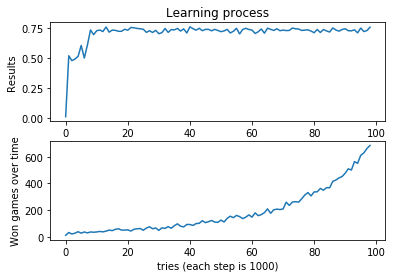

100%|██████████| 99999/99999 [01:13<00:00, 1365.80it/s]


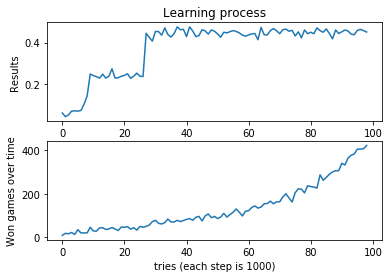

100%|██████████| 99999/99999 [01:16<00:00, 1300.90it/s]


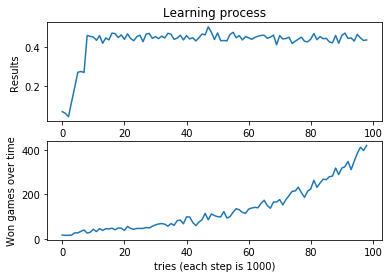

100%|██████████| 99999/99999 [01:32<00:00, 1079.45it/s]


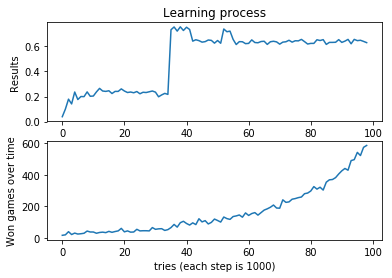

100%|██████████| 99999/99999 [01:36<00:00, 1040.79it/s]


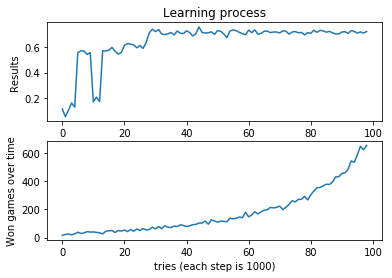

In [12]:
x =[]
y = []
number_of_try = 5
number_of_runs = 100000
q_tables = []
for i in range(number_of_try):
    # train
    q_table, trace_of_learning, trace_of_won = monte_carlo_train(env, number_of_runs=number_of_runs, gama=0.9)
    sleep(0.1)
    # evaluate
    result = evaluate_policy(env, q_table, 1000)
    
    # data for charts
    x.append(i)
    y.append(result)
    q_tables.append(q_table)
    
    # show learning
#     fig, ax = plt.subplots()
#     ax.plot(trace_of_learning)
#     ax.set(xlabel='each step is 1000', ylabel='results', title='Learning process')
#     ax.grid()
#     plt.show()
    
    plt.subplot(2, 1, 1)
    plt.plot(trace_of_learning)
    plt.title('Learning process')
    plt.ylabel('Results')

    plt.subplot(2, 1, 2)
    plt.plot(trace_of_won)
    plt.xlabel('tries (each step is 1000)')
    plt.ylabel('Won games over time')

    plt.show()
    


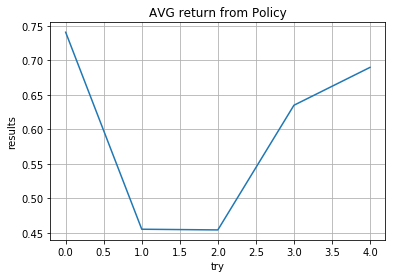

Mean 0.595


In [13]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='try', ylabel='results', title='AVG return from Policy')
ax.grid()

fig.savefig(str(number_of_runs) + '_' + str(number_of_try) + '_plot.png')
plt.show()

print('Mean', np.mean(y))

In [14]:
def get_clean_q_table(q_table):
    clean = np.zeros(q_table.shape)
    for state in range(q_table.shape[0]):
        max_action = np.argmax(q_table[state,:])
        clean[state][max_action] = 1
    return clean

clean_q_table = [] 
total_sum = np.zeros((16,4))
for q_table in q_tables:
    clean_table = get_clean_q_table(q_table)
    clean_q_table.append(clean_table)
    total_sum = np.add(total_sum, clean_table)
    
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for n in range(number_of_try):
#     xs = np.arange(16*4)
#     ys = clean_q_table[n].flatten()
#     ax.bar(xs, ys, zs=n, zdir='y')
# ax.set_xlabel('state-action')
# ax.set_ylabel('tries')
# ax.set_zlabel('value: 0 or 1')
# plt.show()

print(total_sum/number_of_try)


[[ 0.6  0.   0.4  0. ]
 [ 0.   0.   0.   1. ]
 [ 0.4  0.   0.6  0. ]
 [ 0.   0.   0.   1. ]
 [ 1.   0.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.6  0.   0.4  0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]
 [ 0.   1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   1.   0. ]
 [ 0.   0.8  0.2  0. ]
 [ 1.   0.   0.   0. ]]
